# Import the libraries and data 

In [1]:
#import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [2]:
#read cleaned data
df = pd.read_excel('../cleaned_data.xls')
df.head()  #check

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,basement,yr_built,renovated,zipcode,price
0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,221900
1,3,2.25,2570,7242,2.0,0,0,3,7,1,1951,1,98125,538000
2,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,180000
3,4,3.00,1960,5000,1.0,0,0,5,7,1,1965,0,98136,604000
4,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,510000


# Exploratory Data Analysis (EDA)

* Descriptive analysis

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,21597.0,3.373200,0.926299,1.0,3.00,3.00,4.0,33.0
bathrooms,21597.0,2.115826,0.768984,0.5,1.75,2.25,2.5,8.0
sqft_living,21597.0,2080.321850,918.106125,370.0,1430.00,1910.00,2550.0,13540.0
sqft_lot,21597.0,15099.408760,41412.636876,520.0,5040.00,7618.00,10685.0,1651359.0
floors,21597.0,1.494096,0.539683,1.0,1.00,1.50,2.0,3.5
waterfront,21597.0,0.007547,0.086549,0.0,0.00,0.00,0.0,1.0
view,21597.0,0.234292,0.766390,0.0,0.00,0.00,0.0,4.0
condition,21597.0,3.409825,0.650546,1.0,3.00,3.00,4.0,5.0
grade,21597.0,7.657915,1.173200,3.0,7.00,7.00,8.0,13.0
basement,21597.0,0.392971,0.488422,0.0,0.00,0.00,1.0,1.0


* Correlation matrix

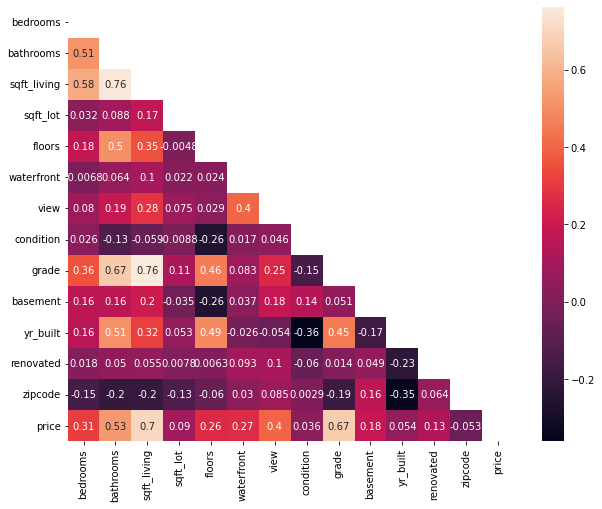

In [4]:
correlations_matrix = df.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

__Remark__:
Analyzing the target correlation with other variables, I decided to select features with correlation higher than 0.25 and later do some transformation to look if the correlation gets higher.

As for multicollinearity, the highest score between features is 0.76, which is not high and can be accepted.

In [5]:
#drop the ones with low correlation and save in another dataframe
df1 = df.drop(['sqft_lot', 'condition', 'basement', 'yr_built','renovated', 'zipcode'], axis = 1)

In [6]:
#check what remained
df1.corr().iloc[-1]  #location of target

bedrooms       0.308787
bathrooms      0.525906
sqft_living    0.701917
floors         0.256804
waterfront     0.266398
view           0.397370
grade          0.667951
price          1.000000
Name: price, dtype: float64

* Visualization

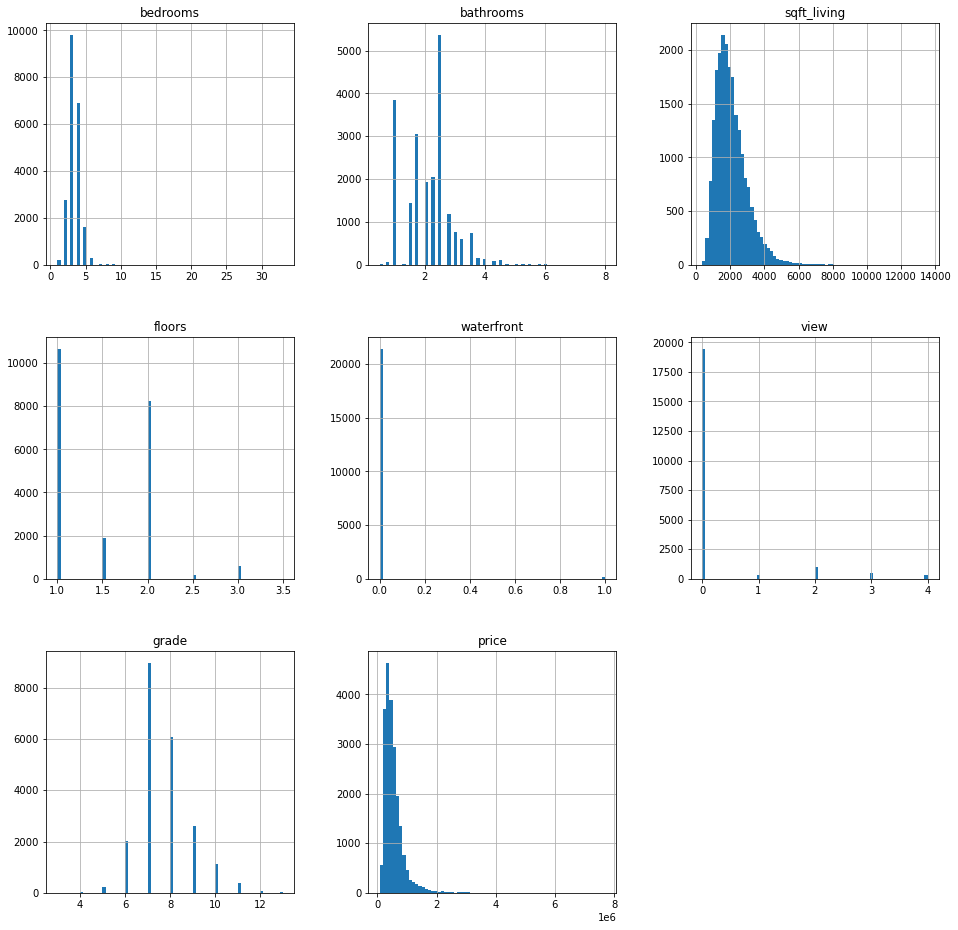

In [7]:
#check the distribution
df1.hist(figsize = (16, 16), bins = 70);

In [8]:
#check the skewness
df1.skew(axis = 0)

bedrooms        2.023641
bathrooms       0.519709
sqft_living     1.473215
floors          0.614497
waterfront     11.380796
view            3.396236
grade           0.788237
price           4.023365
dtype: float64

__Remark__:
All variables, except *floors, waterfront and view* are more or less normally distributed with some skewness and outliers. It will be obvious later if applying transformation correct the distributions.

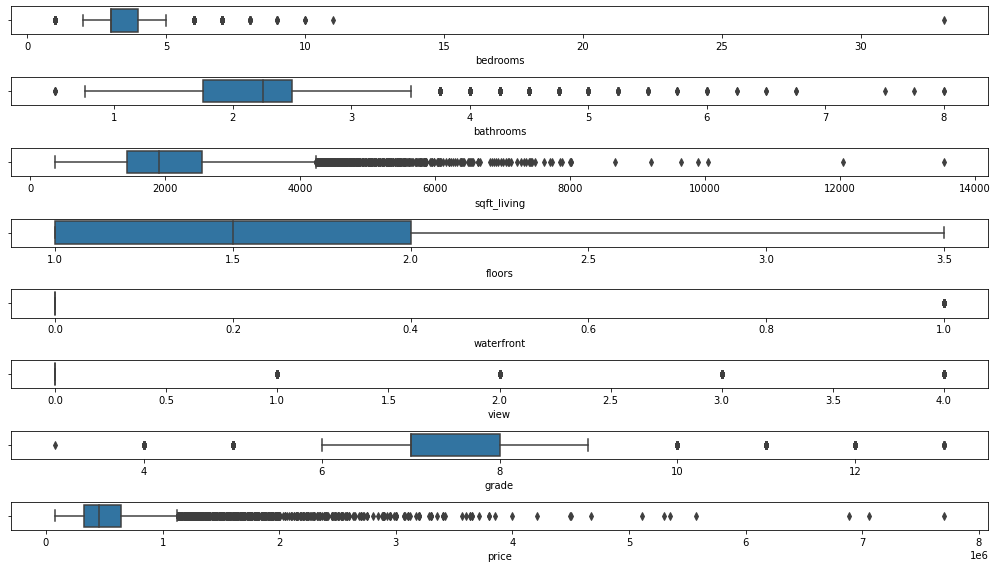

In [9]:
#check outliers
fig, ax = plt.subplots(8,1, figsize = (14,8))
sns.boxplot(df1['bedrooms'], ax = ax[0])
sns.boxplot(df1['bathrooms'], ax = ax[1])
sns.boxplot(df1['sqft_living'], ax = ax[2])
sns.boxplot(df1['floors'], ax = ax[3])
sns.boxplot(df1['waterfront'], ax = ax[4])
sns.boxplot(df1['view'], ax = ax[5])
sns.boxplot(df1['grade'], ax = ax[6])
sns.boxplot(df1['price'], ax = ax[7])
plt.tight_layout()

__Remark__:
There are some outliers, which belong to continious variables *(sqft_living and price)*. If we cut them, there is a high probability to lose some important data. 

With logarithmic or boxcox transformation it is possible to form more normal distribution and remove outliers.

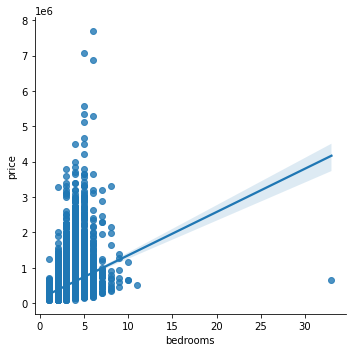

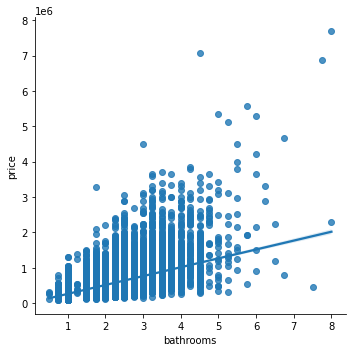

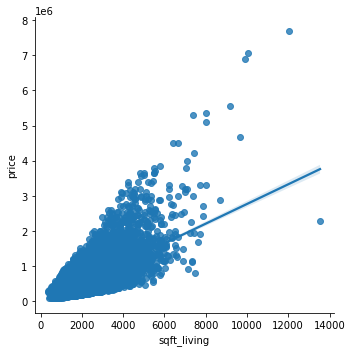

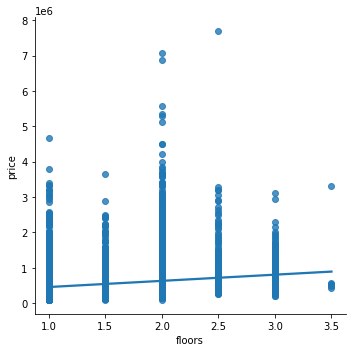

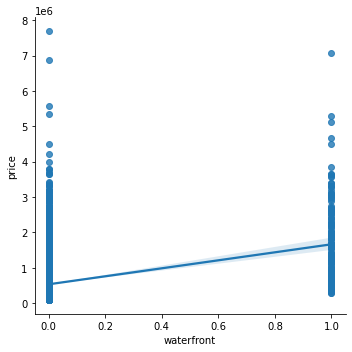

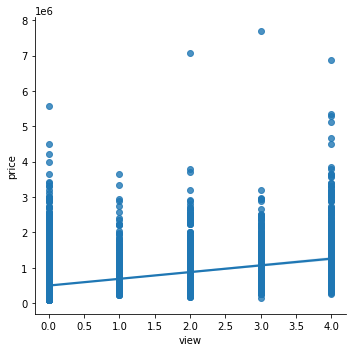

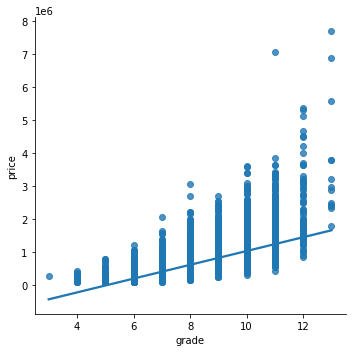

In [10]:
#plot the features with target
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade']
for col in features:
    sns.lmplot(data = df1, x = col, y= 'price')
    plt.show()

* Transformation

In [11]:
#as usual, save any changes to another dataframe
df2 = df1.copy()
df2.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view',
       'grade', 'price'],
      dtype='object')

__Remark:__
I've tried boxcox and log trasformation on different variables and saved the one which somehow increased the correlation and made the distributions more normal.

In [12]:
#as usual, save changes to another dataframe
df2 = df1.copy()

In [13]:
#log transformation
log_transform = lambda x: np.log(x) if np.isfinite(x) and x!=0 else np.NAN
columns = ['bedrooms', 'floors', 'sqft_living', 'grade', 'price']
for col in columns:
    df2[col] = df2[col].apply(log_transform).fillna(df2[col].mean())  #replace infinite and zero values with mean

#boxcox transformation
boxcox_clean = lambda x: 0.5 if x <= 0 else x
columns2 = ['bathrooms', 'view']
for col in columns2:
    df2[col] = df2[col].apply(boxcox_clean)
    fitted_data, fitted_lambda = stats.boxcox(df2[col])
    df2[col] = fitted_data

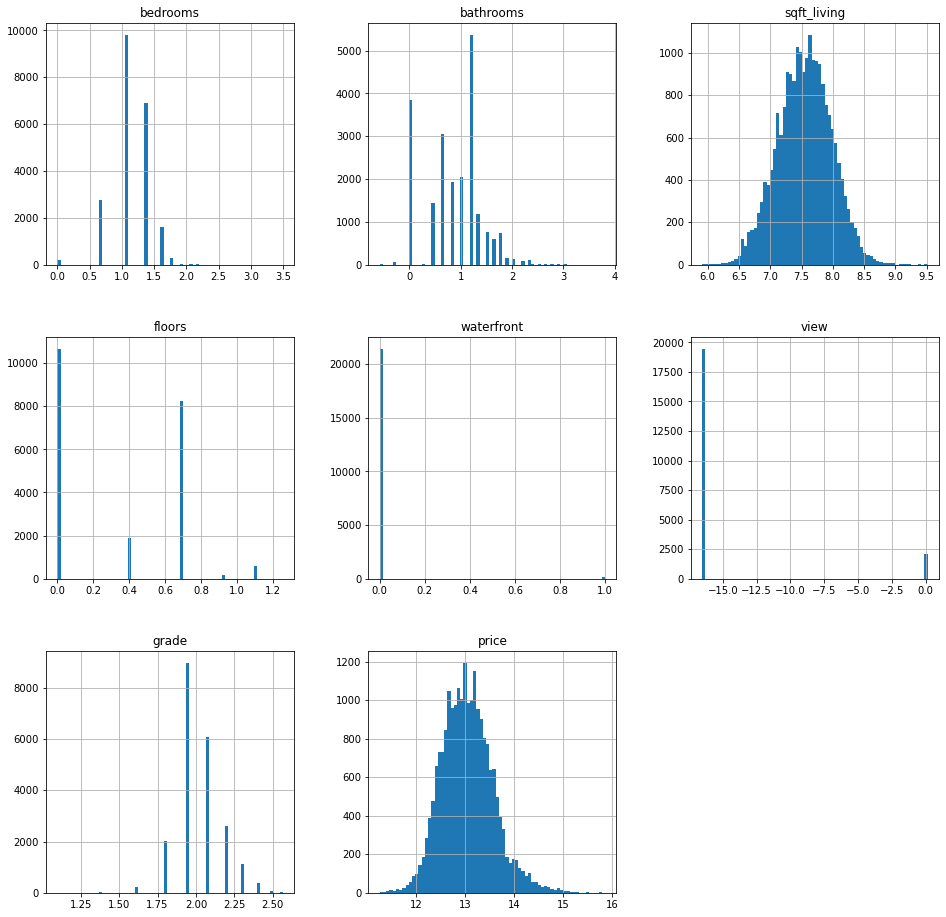

In [14]:
#check distributions
df2.hist(figsize = (16, 16), bins = 70);

In [15]:
round(df2.corr().iloc[-1] - df1.corr().iloc[-1], 3)  #to see the difference on correlation after transformation

bedrooms       0.034
bathrooms      0.014
sqft_living   -0.027
floors         0.066
waterfront    -0.092
view          -0.066
grade          0.026
price          0.000
Name: price, dtype: float64

In [16]:
df2.drop('waterfront', axis = 1, inplace = True)  #drop the one that has correlation < 0.3

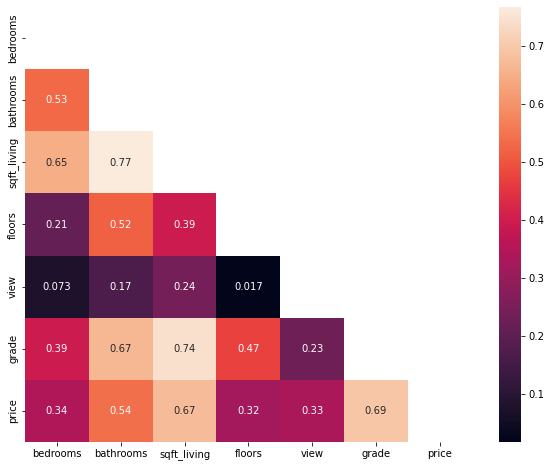

In [17]:
#check matrix
correlations_matrix = df2.corr()
mask = np.zeros_like(correlations_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(correlations_matrix, mask=mask, annot=True)
plt.show()

__Remark:__
We see the changes on distribution and some positive changes on correlation score (however there are some that were reduced). Later it will be clear if the transformed features improve the prediction score.

# Modeling (Price Prediction)

To see the difference on scores and select the one which performs better 3 regression models will be used: 
Linear Regression, KNN Regressor, Decision Tree

The models will be applied to 3 dataframes:
* Transformed one
* Not transformed, but correlation > 0.2
* Not transformed and with all columns

## Linear Regression Model

In [18]:
#set the target and features in 3 different options
y = df.price
X = df.drop('price', axis = 1)  #original data
y1 = df1.price
X1 = df1.drop('price', axis = 1)  #droped low correlation data
y2 = df2.price
X2 = df2.drop('price', axis = 1)  #transformed data

In [19]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 100)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.4, random_state = 100)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.4, random_state = 100)

In [20]:
#apply the model and check the scores
lm = LinearRegression()
model = lm.fit(X2_train, y2_train)
y2_test_predict = lm.predict(X2_test)
print('Linear Regression on transformed data with correlation > 0.3:')
print(f'R2 score: {round(r2_score(y2_test, y2_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y2_test, y2_test_predict, squared = False), 2)}')  
print(f'MAE score: {round(mean_absolute_error(y2_test, y2_test_predict), 2)}')  #error rates are < 1 - what is the reason (?)

Linear Regression on transformed data with correlation > 0.3:
R2 score: 0.56
RMSE score: 0.35
MAE score: 0.28


In [21]:
model = lm.fit(X1_train, y1_train)
y1_test_predict = lm.predict(X1_test)
print('Linear Regression on not transformed data with correlation > 0.2:')
print(f'R2 score: {round(r2_score(y1_test, y1_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y1_test, y1_test_predict, squared = False))}')
print(f'MAE score: {round(mean_absolute_error(y1_test, y1_test_predict))}')

Linear Regression on not transformed data with correlation > 0.2:
R2 score: 0.59
RMSE score: 243436
MAE score: 156619


In [57]:
model = lm.fit(X_train, y_train)
y_test_predict = lm.predict(X_test)
print('Linear Regression on not transformed data including all variables:')
print(f'R2 score: {round(r2_score(y_test, y_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y_test, y_test_predict, squared = False))}')
print(f'MAE score: {round(mean_absolute_error(y_test, y_test_predict))}')

Linear Regression on not transformed data including all variables:
R2 score: 0.65
RMSE score: 226079
MAE score: 140726


__Remark:__
The best Linear Model scores are reached when applied to the original data, with more features and different correlations. It seems that this model works better with more independent variables.

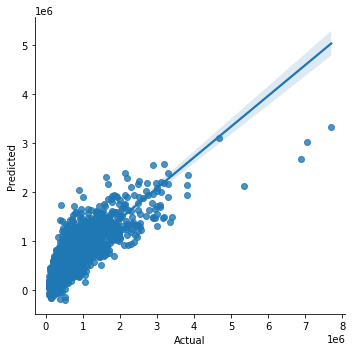

In [61]:
#let's visualize the Linear Model with best performance
lm_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_predict})
sns.lmplot(data = lm_df, x = 'Actual', y= 'Predicted')
plt.show()

## KNN Regression Model

In [30]:
#knn works better with scaled features
#save as an option to apply the model
transformer = StandardScaler().fit(X1)
X3 = transformer.transform(X1)

In [31]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 100)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.4, random_state = 100)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y1, test_size = 0.4, random_state = 100)

In [32]:
scores = []  #to see how many neighbors selected give better score
for k in range(5,20):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X3_train, y3_train)
    scores.append(model.score(X3_test, y3_test))

Text(0, 0.5, 'Accuracy')

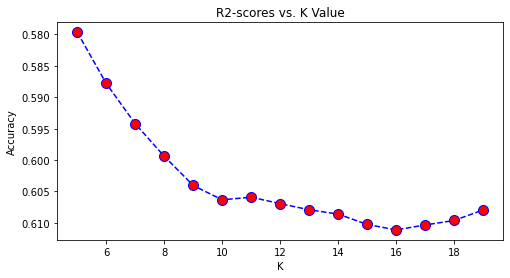

In [33]:
#visualize the scores
plt.figure(figsize=(8,4))
plt.plot(range(5,20),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('R2-scores vs. K Value')
plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('Accuracy')  #k value 16 can be used

In [34]:
#do the same with other options
scores1 = []
for k in range(5,20):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X2_train, y2_train)
    scores1.append(model.score(X2_test, y2_test))

Text(0, 0.5, 'Accuracy')

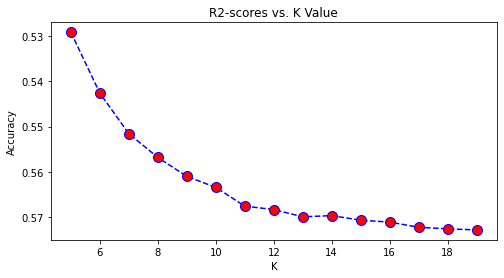

In [35]:
plt.figure(figsize=(8,4))
plt.plot(range(5,20), scores1, color = 'blue', linestyle = 'dashed',
         marker ='o', markerfacecolor = 'red', markersize = 10)
plt.title('R2-scores vs. K Value')
plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('Accuracy')

In [36]:
scores2 = []
for k in range(5,20):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    scores2.append(model.score(X_test, y_test))

Text(0, 0.5, 'Accuracy')

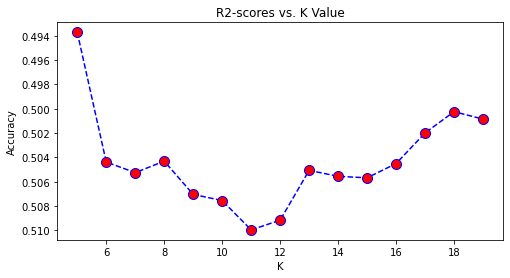

In [37]:
plt.figure(figsize=(8,4))
plt.plot(range(5,20), scores2, color = 'blue', linestyle = 'dashed',
         marker ='o', markerfacecolor = 'red', markersize = 10)
plt.title('R2-scores vs. K Value')
plt.gca().invert_yaxis()
plt.xlabel('K')
plt.ylabel('Accuracy')

__Remark:__
The best scores are reached whith scaled features. Let's apply and visualize the model.

In [38]:
knn = KNeighborsRegressor(n_neighbors=16)
model = knn.fit(X3_train, y3_train)
y3_test_predict = knn.predict(X3_test)
print('KNN Regression on standardized data:')
print(f'R2 score: {round(r2_score(y3_test, y3_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y3_test, y3_test_predict, squared = False))}')
print(f'MAE score: {round(mean_absolute_error(y3_test, y3_test_predict))}')

KNN Regression on standardized data:
R2 score: 0.61
RMSE score: 237563
MAE score: 145178


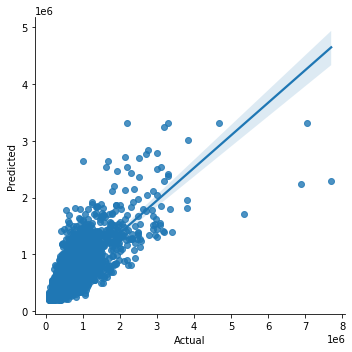

In [59]:
knn_df = pd.DataFrame({'Actual': y3_test, 'Predicted': y3_test_predict})
sns.lmplot(data = knn_df, x = 'Actual', y= 'Predicted')
plt.show()

## Random Forest Regression Model 

In [40]:
#do the same as with Linear Model and compare the scores
rf = RandomForestRegressor(n_estimators=100)
model = rf.fit(X2_train, y2_train)
y2_test_predict = rf.predict(X2_test)
print('KNN Regression on standardized data:')
print(f'R2 score: {round(r2_score(y2_test, y2_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y2_test, y2_test_predict, squared = False), 2)}')
print(f'MAE score: {round(mean_absolute_error(y2_test, y2_test_predict), 2)}')

KNN Regression on standardized data:
R2 score: 0.52
RMSE score: 0.37
MAE score: 0.29


In [41]:
rf = RandomForestRegressor(n_estimators=100)
model = rf.fit(X1_train, y1_train)
y1_test_predict = rf.predict(X1_test)
print('KNN Regression on standardized data:')
print(f'R2 score: {round(r2_score(y1_test, y1_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y1_test, y1_test_predict, squared = False))}')
print(f'MAE score: {round(mean_absolute_error(y1_test, y1_test_predict))}')

KNN Regression on standardized data:
R2 score: 0.6
RMSE score: 240371
MAE score: 153676


In [42]:
rf = RandomForestRegressor(n_estimators=100)
model = rf.fit(X_train, y_train)
y_test_predict = rf.predict(X_test)
print('KNN Regression on standardized data:')
print(f'R2 score: {round(r2_score(y_test, y_test_predict), 2)}')
print(f'RMSE score: {round(mean_squared_error(y_test, y_test_predict, squared = False))}')
print(f'MAE score: {round(mean_absolute_error(y_test, y_test_predict))}')

KNN Regression on standardized data:
R2 score: 0.8
RMSE score: 172075
MAE score: 91091


__Remark:__
The last one (using original data) shows the best results. Let's visualize to compare with previous models.

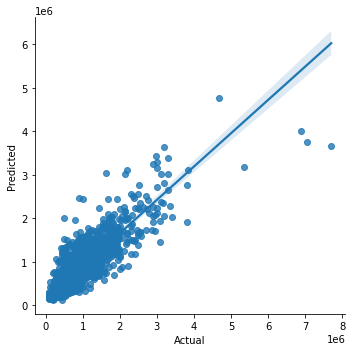

In [56]:
rf_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_predict})
sns.lmplot(data = rf_df, x = 'Actual', y= 'Predicted')
plt.show()

__Result:__
I would use Random Forest Model to predict the prices.